# Modelagem Preditiva de Séries Temporais - Em Python

# <font color='blue'>Deep Learning - Recurrent Neural Networks (RNN)</font>

Todas as aulas deste curso foram adaptadas da timeline da Comunidade no Portal da DSA: www.datascienceacademy.com.br

# Redes Neurais Recorrentes LSTM - Long Short-Term Memory 

Este Notebook está dividido nas seguintes etapas. Clique no título da etapa para acessá-la diretamente.

* [Etapa 1](#etapa1): Conjunto de dados
* [Etapa 2](#etapa2): Importar as Bibliotecas
* [Etapa 3](#etapa3): Criar o Modelo
* [Etapa 4](#etapa4): Testar o Modelo
* [Etapa 5](#etapa5): Realizar as Previsões

## Prevendo Séries Temporais com LSTMs e Método Window

Podemos também explicar o problema de modo que várias etapas de tempo anteriores possam ser usadas para previsão do próximo passo. Isso é chamado de janela (window) e o tamanho da janela é um parâmetro que pode ser configurado para cada problema.

<a id = 'etapa1'></a>
## Etapa 1: Conjunto de dados

Previsão de Capacidade do Mainframe - Consumo dos Jobs do Broker

Usaremos conjuntos de dados que mostram o Consumo dos Jobs do Broker. 

<a id='etapa2'></a>
## Etapa 2: Importar as Bibliotecas

In [1]:
# Importa TF2
import tensorflow as tf
tf.__version__

'2.10.0'

In [2]:
# Imports
import math
import numpy
import pandas as pd
import os
import io
import requests

from pandas.tseries.offsets import DateOffset
from time import time
from datetime import datetime

# Importa Keras TF2
from tensorflow import keras   
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [3]:
# Converte array em matriz
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [4]:
# Define o PATH onde estão os dados
save_path = "./save"

# Random seed 
numpy.random.seed(7)

look_back = 10

Clique no título da etapa para acessá-la diretamente.

* [Etapa 3](#etapa3): Criar o Modelo
* [Etapa 4](#etapa4): Testar o Modelo
* [Etapa 5](#etapa5): Realizar as Previsões

<a id='etapa3'></a>
## Etapa 3: Criar o Modelo

In [5]:
# Carrega os dataframe
dataframe = pd.read_csv("./CSV/pipaColBrokerDia.csv")
dataframe['DATA'] = pd.to_datetime(dataframe.DATA, format = '%Y-%m-%dT%H:%M:%S.%fZ')
dataframe.rename(columns={'DATA': 'Data'}, inplace=True)
dataframe = dataframe[['Data','BROKER','SERVICE_NAME','SERVICE_CLASS','PROGRAMA', 'QUANTIDADE']]
dataframe.rename(columns={'BROKER': 'Broker', 'SERVICE_NAME': 'Service_name', 'SERVICE_CLASS': 'Service_class',
                      'PROGRAMA': 'Programa', 'QUANTIDADE': 'Quantidade'}, inplace=True)
dataframe

,Data,Broker,Service_name,Service_class,Programa,Quantidade
0,2021-11-27,ETB160,DETRAN,SDGX,NSDGX047,6
1,2021-11-27,ETB160,DETRAN,SDGX,NSDAKG12,1
2,2021-11-27,ETB160,DETRAN,SDGX,NSDAKQ08,1
3,2021-11-27,ETB160,DETRAN,SDGX,NSDAKQ07,1
4,2021-11-27,ETB160,DETRAN,SDGX,NSDGX414,1
...,...,...,...,...,...,...
71289,2022-10-24,ETB170,PORTALDETRAN,SDGX,NSDGX500,217
71290,2022-10-24,ETB170,PORTALDETRAN,SDGX,NSDGX495,9
71291,2022-10-24,ETB170,PORTALDETRAN,SDGX,NSDGX469,121
71292,2022-10-24,ETB170,PORTALDETRAN,SDGX,NSDGX467,12


In [6]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71294 entries, 0 to 71293
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Data           71294 non-null  datetime64[ns]
 1   Broker         71294 non-null  object        
 2   Service_name   71294 non-null  object        
 3   Service_class  71294 non-null  object        
 4   Programa       71294 non-null  object        
 5   Quantidade     71294 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 3.3+ MB


In [7]:
# Carregando os dados
# Podemos carregar este conjunto de dados facilmente usando a biblioteca Pandas. Não estamos interessados na data,
# pois que cada observação é separada pelo mesmo intervalo de um mês. Portanto, quando
# carregamos o conjunto de dados, podemos excluir a primeira coluna. O conjunto de dados baixado também tem rodapé
# com informações que podemos excluir com o argumento skipfooter para pandas.read_csv() 
# Uma vez carregado, podemos plotar facilmente todo o conjunto de dados. 

datasetfull = dataframe.copy()

filtro1 = datasetfull['Broker']=='ETB170'
filtro2 = datasetfull['Service_name']=='PORTALDETRAN'
filtro3 = datasetfull['Programa']=='NSDGX500'
datasetfull = datasetfull[filtro1 & filtro2 & filtro3]

datasetfull = datasetfull.rename_axis('index').reset_index()
datasetfull.drop(columns=['index','Broker','Service_name','Service_class','Programa'], inplace=True)
datasetfull

,Data,Quantidade
0,2021-11-27,96
1,2021-11-26,82
2,2021-11-25,50
3,2021-11-24,50
4,2021-11-23,100
...,...,...
572,2022-10-21,78
573,2022-10-22,65
574,2022-10-24,79
575,2022-10-25,176


In [8]:
# Remove as linhas com as datas duplicadas
# Vamos transformar a coluna de data no índice do conjunto de dados. Isso vai facilitar nosso trabalho mais a frente.
# inclui dados missing com a interpolação 

datasetfull.drop_duplicates(subset='Data', inplace=True)
datasetfull = datasetfull.set_index('Data')
datasetfull = datasetfull.resample('D').interpolate()
datasetfull

,Quantidade
Data,
2021-10-26,162.0
2021-10-27,66.0
2021-10-28,58.0
2021-10-29,44.0
2021-10-30,83.0
...,...
2022-10-21,207.0
2022-10-22,22.0
2022-10-23,50.5


In [9]:
datasetfull = datasetfull.values
datasetfull = datasetfull.astype('float32')

In [10]:
# Dados
datasetfull

array([[162.      ],
       [ 66.      ],
       [ 58.      ],
       [ 44.      ],
       [ 83.      ],
       [ 84.5     ],
       [ 86.      ],
       [ 87.      ],
       [ 88.      ],
       [ 63.      ],
       [212.      ],
       [ 64.      ],
       [ 90.5     ],
       [117.      ],
       [ 50.      ],
       [115.      ],
       [ 54.      ],
       [ 92.      ],
       [124.      ],
       [103.333336],
       [ 82.666664],
       [ 62.      ],
       [106.      ],
       [ 33.      ],
       [120.      ],
       [107.      ],
       [145.5     ],
       [184.      ],
       [100.      ],
       [ 50.      ],
       [ 50.      ],
       [ 82.      ],
       [ 96.      ],
       [ 83.      ],
       [ 70.      ],
       [ 98.      ],
       [  4.      ],
       [111.      ],
       [194.      ],
       [  3.      ],
       [ 48.5     ],
       [ 94.      ],
       [ 95.      ],
       [135.      ],
       [ 14.      ],
       [  4.      ],
       [215.      ],
       [109. 

In [11]:
# Split em treino e teste
train_size = int(len(datasetfull) * 0.75)
test_size = len(datasetfull) - train_size
dataset, test = datasetfull[0:train_size,:], datasetfull[train_size:len(datasetfull),:]

In [12]:
# Normaliza os dados
# As LSTMs são sensíveis à escala dos dados de entrada, especificamente quando funções de ativação sigmoide (padrão)
# ou tanh são usadas. Pode ser uma boa prática redimensionar os dados para o range de 0 a 1, 
# também chamado de normalização. Podemos normalizar facilmente o conjunto de dados usando a classe MinMaxScaler do scikit-learn
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)

In [13]:
# Split em treino e validação
train_size = int(len(dataset) * 0.67)
valid_size = len(dataset) - train_size
train, valid = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [14]:
dataset.shape

(273, 1)

In [15]:
train.shape

(182, 1)

In [16]:
valid.shape

(91, 1)

In [17]:
test.shape

(92, 1)

In [18]:
# Reshape em X=t e Y=t+1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)

# Reshape do input para: [samples, time steps, features]
# A rede LSTM espera que os dados de entrada (X) sejam fornecidos com uma estrutura de matriz específica 
# na forma de: [amostras, etapas de tempo, características]. Nossos dados preparados estão na forma: [amostras,
# features] e estamos enquadrando o problema como um único passo para cada amostra. Podemos transformar
# os dados de treino e de teste na estrutura esperada usando numpy.reshape() 
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = numpy.reshape(validX, (validX.shape[0], 1, validX.shape[1]))

In [19]:
# Cria o modelo LSTM
# Agora estamos prontos para projetar nossa rede LSTM para esse problema. A rede tem uma
# camada visível com 1 entrada, uma camada oculta com 4 blocos LSTM ou neurônios e uma camada de saída
# que faz uma previsão de valor único. A função de ativação sigmoid padrão é usada para
# os blocos de memória LSTM. A rede é treinada em 200 épocas e um tamanho de lote (batch_size) de 1 é usado.

# Treinamento
start = time()
current_time = datetime.now().strftime("%H:%M:%S")
print("Hora de Início =", current_time)

model = Sequential()
model.add(LSTM(4, input_shape = (1, look_back)))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

# Early stoppping
monitor = EarlyStopping(monitor = 'val_loss', min_delta = 1e-4, patience = 5, verbose = 1, mode = 'auto')

model.fit(trainX, trainY, epochs = 200, batch_size = 1, verbose = 2)

#model.fit(trainX, trainY, validation_data = (validX, validY), callbacks = [monitor], verbose = 2, epochs = 200)

current_time = datetime.now().strftime("%H:%M:%S")
print("\nHora de Término =", current_time)    
print ('Tempo gasto: %s segundos' % str(time() - start))

Hora de Início = 21:54:00
Epoch 1/200
171/171 - 4s - loss: 0.0921 - 4s/epoch - 21ms/step
Epoch 2/200
171/171 - 1s - loss: 0.0388 - 940ms/epoch - 5ms/step
Epoch 3/200
171/171 - 1s - loss: 0.0377 - 937ms/epoch - 5ms/step
Epoch 4/200
171/171 - 1s - loss: 0.0368 - 956ms/epoch - 6ms/step
Epoch 5/200
171/171 - 1s - loss: 0.0361 - 917ms/epoch - 5ms/step
Epoch 6/200
171/171 - 1s - loss: 0.0357 - 928ms/epoch - 5ms/step
Epoch 7/200
171/171 - 1s - loss: 0.0355 - 971ms/epoch - 6ms/step
Epoch 8/200
171/171 - 1s - loss: 0.0346 - 939ms/epoch - 5ms/step
Epoch 9/200
171/171 - 1s - loss: 0.0344 - 941ms/epoch - 6ms/step
Epoch 10/200
171/171 - 1s - loss: 0.0341 - 948ms/epoch - 6ms/step
Epoch 11/200
171/171 - 1s - loss: 0.0336 - 936ms/epoch - 5ms/step
Epoch 12/200
171/171 - 1s - loss: 0.0336 - 937ms/epoch - 5ms/step
Epoch 13/200
171/171 - 1s - loss: 0.0332 - 944ms/epoch - 6ms/step
Epoch 14/200
171/171 - 1s - loss: 0.0330 - 944ms/epoch - 6ms/step
Epoch 15/200
171/171 - 1s - loss: 0.0324 - 921ms/epoch - 5ms/

Epoch 125/200
171/171 - 1s - loss: 0.0277 - 929ms/epoch - 5ms/step
Epoch 126/200
171/171 - 1s - loss: 0.0278 - 936ms/epoch - 5ms/step
Epoch 127/200
171/171 - 1s - loss: 0.0274 - 930ms/epoch - 5ms/step
Epoch 128/200
171/171 - 1s - loss: 0.0274 - 927ms/epoch - 5ms/step
Epoch 129/200
171/171 - 1s - loss: 0.0278 - 921ms/epoch - 5ms/step
Epoch 130/200
171/171 - 1s - loss: 0.0276 - 938ms/epoch - 5ms/step
Epoch 131/200
171/171 - 1s - loss: 0.0273 - 908ms/epoch - 5ms/step
Epoch 132/200
171/171 - 1s - loss: 0.0273 - 948ms/epoch - 6ms/step
Epoch 133/200
171/171 - 1s - loss: 0.0270 - 909ms/epoch - 5ms/step
Epoch 134/200
171/171 - 1s - loss: 0.0275 - 899ms/epoch - 5ms/step
Epoch 135/200
171/171 - 1s - loss: 0.0273 - 923ms/epoch - 5ms/step
Epoch 136/200
171/171 - 1s - loss: 0.0272 - 910ms/epoch - 5ms/step
Epoch 137/200
171/171 - 1s - loss: 0.0273 - 950ms/epoch - 6ms/step
Epoch 138/200
171/171 - 1s - loss: 0.0271 - 954ms/epoch - 6ms/step
Epoch 139/200
171/171 - 1s - loss: 0.0272 - 947ms/epoch - 6ms/

In [20]:
# Salvando a rede inteira no formato HDF5 (salvando todos os componentes da rede, incluindo os pesos)
model.save(os.path.join(save_path,"RNN02_PipaMainframe_LSTM_Window.h5"))

<a id='etapa4'></a>
## Etapa 4: Testar o Modelo

## Agora recarregamos o modelo para realizamos uma previsão.

In [21]:
# Carregando os dados
datasetfull = dataframe.copy()

filtro1 = datasetfull['Broker']=='ETB170'
filtro2 = datasetfull['Service_name']=='PORTALDETRAN'
filtro3 = datasetfull['Programa']=='NSDGX500'
datasetfull = datasetfull[filtro1 & filtro2 & filtro3]

datasetfull = datasetfull.rename_axis('index').reset_index()
datasetfull.drop(columns=['index','Broker','Service_name','Service_class','Programa'], inplace=True)

datasetfull.drop_duplicates(subset='Data', inplace=True)
datasetfull = datasetfull.set_index('Data')
datasetfull = datasetfull.resample('D').interpolate()

datasetfull = datasetfull.values
datasetfull = datasetfull.astype('float32')

# Split em treino e teste
train_size = int(len(datasetfull) * 0.75)
test_size = len(datasetfull) - train_size
dataset, test = datasetfull[0:train_size,:], datasetfull[train_size:len(datasetfull),:]

# Normaliza os dados
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)

# Split em treino e validação
train_size = int(len(dataset) * 0.67)
valid_size = len(dataset) - train_size
train, valid = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape em X=t e Y=t+1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)

# Reshape do input para: [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = numpy.reshape(validX, (validX.shape[0], 1, validX.shape[1]))

In [22]:
#carrega o modelo
model = load_model(os.path.join(save_path,"RNN02_PipaMainframe_LSTM_Window.h5"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 240       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Previsões
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)

3/3 [==============================] - 0s 4ms/step


In [24]:
# Inverte as previsões por conta da normalização
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])

In [25]:
# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.4f RMSE' % (trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('Score em Validação: %.4f RMSE' % (validScore))

Score em Treino: 48.7170 RMSE
Score em Validação: 67.1578 RMSE


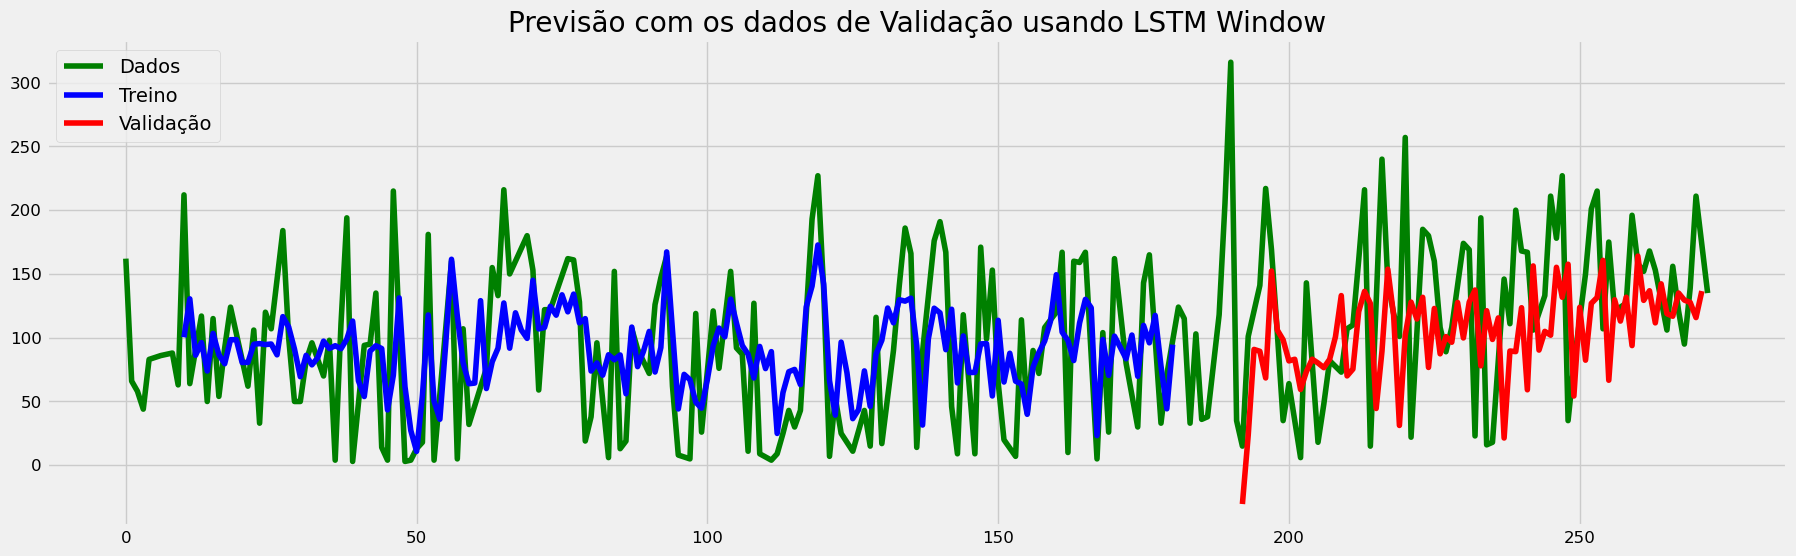

In [26]:
# Ajusta as previsões em treino para o plot
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Ajusta as previsões em validação para o plot
validPredictPlot = numpy.empty_like(dataset)
validPredictPlot[:, :] = numpy.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = validPredict

# Plot do baseline e previsões
plt.figure(figsize = (20, 6))
plt.title("Previsão com os dados de Validação usando LSTM Window") 
plt.plot(scaler.inverse_transform(dataset), label = 'Dados',color = 'green')
plt.plot(trainPredictPlot, label = 'Treino', color = 'blue')
plt.plot(validPredictPlot, label = 'Validação', color = 'red')
plt.legend(loc = 'upper left') 
plt.show()

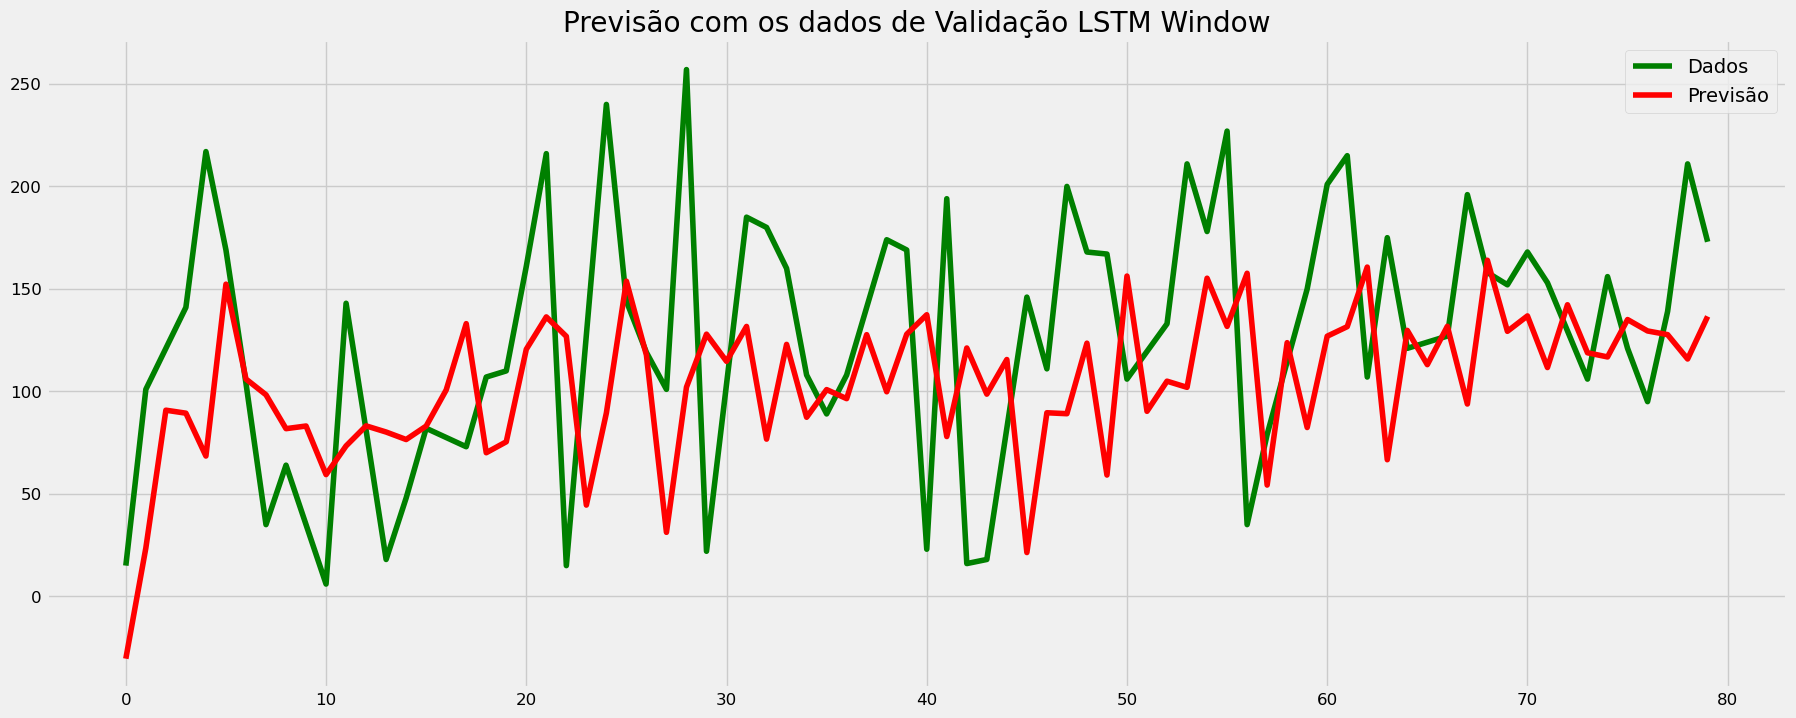

In [27]:
# Plot do baseline e previsões
plt.figure(figsize = (20, 8))
plt.title("Previsão com os dados de Validação LSTM Window") 
plt.plot(validY[0], label = 'Dados', color = 'green') 
plt.plot(validPredict[:,0], label = 'Previsão', color = 'red') 
plt.legend(loc = 'best') 
plt.show()

In [28]:
# Carregando os dados
datasetfull = dataframe.copy()

filtro1 = datasetfull['Broker']=='ETB170'
filtro2 = datasetfull['Service_name']=='PORTALDETRAN'
filtro3 = datasetfull['Programa']=='NSDGX500'
datasetfull = datasetfull[filtro1 & filtro2 & filtro3]

datasetfull = datasetfull.rename_axis('index').reset_index()
datasetfull.drop(columns=['index','Broker','Service_name','Service_class','Programa'], inplace=True)

datasetfull.drop_duplicates(subset='Data', inplace=True)
datasetfull = datasetfull.set_index('Data')
datasetfull = datasetfull.resample('D').interpolate()

datasetfull = datasetfull.values
datasetfull = datasetfull.astype('float32')

# Split em treino e teste
train_size = int(len(datasetfull) * 0.75)
test_size = len(datasetfull) - train_size
dataset, test = datasetfull[0:train_size,:], datasetfull[train_size:len(datasetfull),:]

# Normaliza os dados
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)

# Normaliza os dados de Teste
scalerTeste = MinMaxScaler(feature_range = (0, 1))
testScaler = scalerTeste.fit_transform(test)

# Split em treino e validação
train_size = int(len(dataset) * 0.67)
valid_size = len(dataset) - train_size
train, valid = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape em X=t e Y=t+1
trainX, trainY = create_dataset(train, look_back)
validX, validY = create_dataset(valid, look_back)
testX, testY = create_dataset(testScaler, look_back)

# Reshape do input para: [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
validX = numpy.reshape(validX, (validX.shape[0], 1, validX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [29]:
#carrega o modelo
model = load_model(os.path.join(save_path,"RNN02_PipaMainframe_LSTM_Window.h5"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 240       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Previsões com dados de Teste
trainPredict = model.predict(trainX)
validPredict = model.predict(validX)
testPredict = model.predict(testX)

3/3 [==============================] - 0s 4ms/step


In [31]:
# Inverte as previsões por conta da normalização
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
validPredict = scaler.inverse_transform(validPredict)
validY = scaler.inverse_transform([validY])
testPredict = scalerTeste.inverse_transform(testPredict)
testY = scalerTeste.inverse_transform([testY])

In [32]:
# Calcula o RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Score em Treino: %.4f RMSE' % (trainScore))
validScore = math.sqrt(mean_squared_error(validY[0], validPredict[:,0]))
print('Score em Validação: %.4f RMSE' % (validScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Score em Teste: %.4f RMSE' % (testScore))

Score em Treino: 48.7170 RMSE
Score em Validação: 67.1578 RMSE
Score em Teste: 85.3992 RMSE


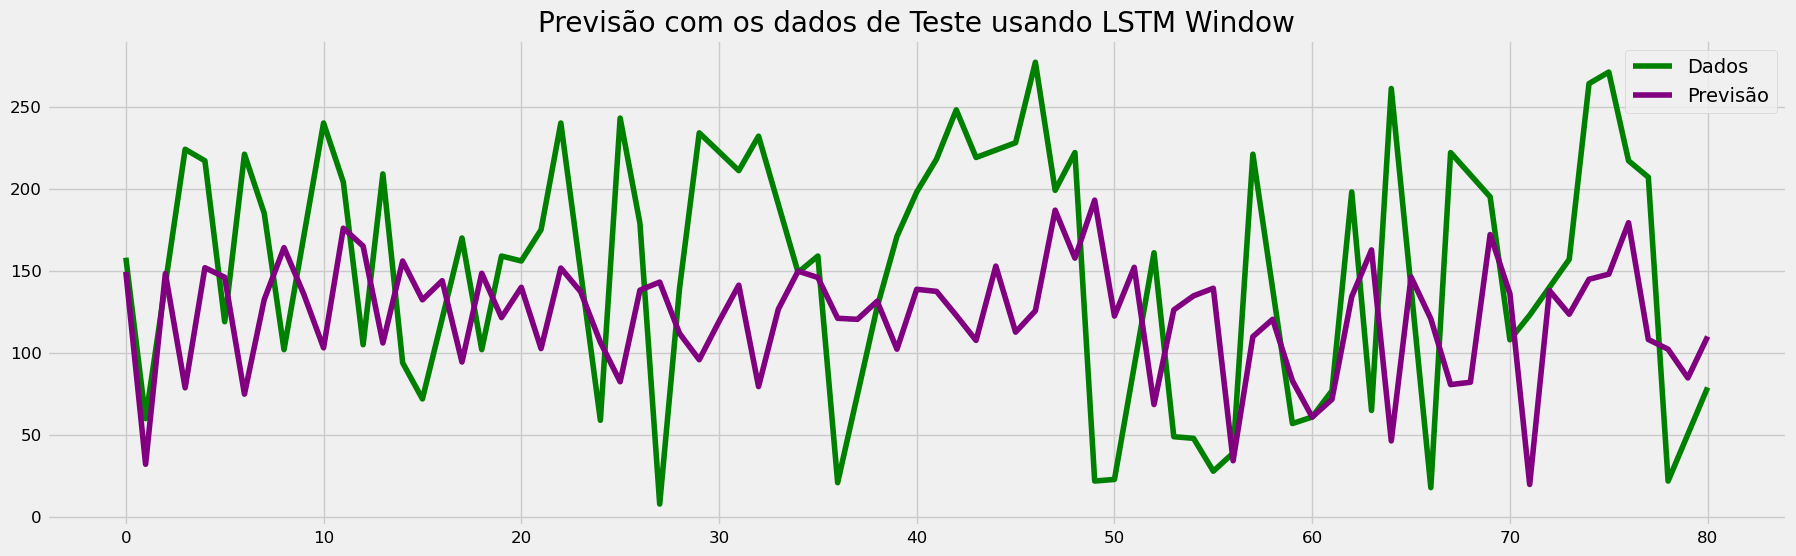

In [33]:
# Plot do baseline e previsões
plt.figure(figsize = (20, 6))
plt.title("Previsão com os dados de Teste usando LSTM Window") 
plt.plot(testY[0], label = 'Dados', color = 'green') 
plt.plot(testPredict[:,0], label = 'Previsão', color = 'purple') 
plt.legend(loc = 'best') 
plt.show()

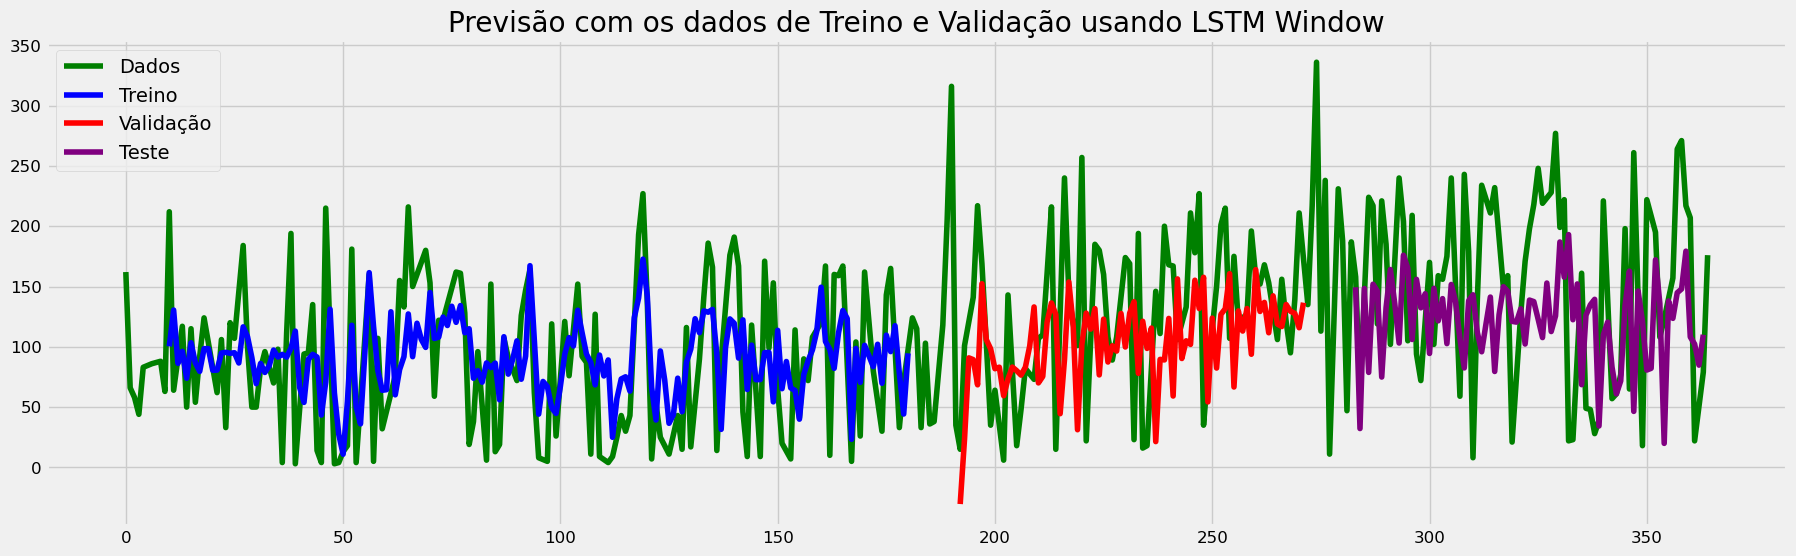

In [34]:
# Ajusta as previsões em treino para o plot
trainPredictPlot = numpy.empty_like(datasetfull)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# Ajusta as previsões em validação para o plot
validPredictPlot = numpy.empty_like(dataset)
validPredictPlot[:, :] = numpy.nan
validPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = validPredict

# Ajusta as previsões em validação para o plot
testPredictPlot = numpy.empty_like(datasetfull)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[(len(trainPredict) + len(validPredict))+(look_back*3)+2:len(datasetfull)-1, :] = testPredict

# Plot do baseline e previsões
plt.figure(figsize = (20, 6))
plt.title("Previsão com os dados de Treino e Validação usando LSTM Window") 
#plt.plot(datasetfull, label = 'Dados', color = 'green')
plt.plot(datasetfull, label = 'Dados',color = 'green')
plt.plot(trainPredictPlot, label = 'Treino', color = 'blue')
plt.plot(validPredictPlot, label = 'Validação', color = 'red')
plt.plot(testPredictPlot, label = 'Teste', color = 'purple')
plt.legend(loc = 'upper left') 
plt.show()

<a id='etapa5'></a>
## Etapa 5: Realizar as Previsões

## Vamos fazer o Forecasting para 82 dias de previsão

In [35]:
# Carregando os dados
datasetfull = dataframe.copy()

filtro1 = datasetfull['Broker']=='ETB170'
filtro2 = datasetfull['Service_name']=='PORTALDETRAN'
filtro3 = datasetfull['Programa']=='NSDGX500'
datasetfull = datasetfull[filtro1 & filtro2 & filtro3]

datasetfull.drop(columns=['Broker','Service_name','Service_class','Programa'], inplace=True)

datasetfull.drop_duplicates(subset='Data', inplace=True)
datasetfull = datasetfull.set_index('Data')
datasetfull = datasetfull.resample('D').interpolate()

# Refinamos os dados para o gráfico da série original
# A variável Quantidade é nossa variável target 
target = datasetfull['Quantidade']
raw_values = target.values

datasetfull = datasetfull.values
datasetfull = datasetfull.astype('float32')

# Split em treino e teste
train_size = int(len(datasetfull) * 0.75)
test_size = len(datasetfull) - train_size
dataset, test = datasetfull[0:train_size,:], datasetfull[train_size:len(datasetfull),:]

# Normaliza os dados
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)

# Normaliza os dados de Teste
scalerTeste = MinMaxScaler(feature_range = (0, 1))
testScaler = scalerTeste.fit_transform(test)

# Split em treino e validação
train_size = int(len(dataset) * 0.67)
valid_size = len(dataset) - train_size
train, valid = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape em X=t e Y=t+1
trainX1, trainY = create_dataset(train, look_back)
validX1, validY = create_dataset(valid, look_back)
testX1, testY = create_dataset(testScaler, look_back)

# Reshape do input para: [samples, time steps, features]
trainX = numpy.reshape(trainX1, (trainX1.shape[0], 1, trainX1.shape[1]))
validX = numpy.reshape(validX1, (validX1.shape[0], 1, validX1.shape[1]))
testX = numpy.reshape(testX1, (testX1.shape[0], 1, testX1.shape[1]))

In [36]:
#carrega o modelo
model = load_model(os.path.join(save_path,"RNN02_PipaMainframe_LSTM_Window.h5"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 240       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Fazemos uma previsão em uma etapa
def forecast_lstm(model, X):
    X = X.reshape(1, 1, look_back)
    yhat = model.predict(X)
    yhat1 = scaler.inverse_transform(yhat)
    return yhat1[0,0]

In [38]:
# Validação direta nos dados de teste

# Lista para as previsões
previsoes_lstm = list()

# Previsões

for i in range(len(testX1)):   
   
    # Ajusta o shape dos dados de teste
    X, y = testX1[i], testY[i]
    
    # Previsão

    yhat = forecast_lstm(model, X)
    
    # Armazena o forecast
    previsoes_lstm.append(yhat)
    expected = raw_values[len(testX1) + i ]
    
    print('Mês = %d, Valor Previsto = %f, Valor Esperado = %f' % (i + 1, yhat, expected))

1/1 [==============================] - 0s 425ms/step
Mês = 1, Valor Previsto = 137.905396, Valor Esperado = 96.000000
1/1 [==============================] - 0s 26ms/step
Mês = 2, Valor Previsto = 26.101181, Valor Esperado = 51.000000
1/1 [==============================] - 0s 26ms/step
Mês = 3, Valor Previsto = 136.929626, Valor Esperado = 6.000000
1/1 [==============================] - 0s 26ms/step
Mês = 4, Valor Previsto = 70.529633, Valor Esperado = 152.000000
1/1 [==============================] - 0s 27ms/step
Mês = 5, Valor Previsto = 140.316162, Valor Esperado = 13.000000
1/1 [==============================] - 0s 25ms/step
Mês = 6, Valor Previsto = 134.754883, Valor Esperado = 19.000000
1/1 [==============================] - 0s 29ms/step
Mês = 7, Valor Previsto = 66.855431, Valor Esperado = 107.000000
1/1 [==============================] - 0s 26ms/step
Mês = 8, Valor Previsto = 121.797409, Valor Esperado = 91.000000
1/1 [==============================] - 0s 29ms/step
Mês = 9, Valo

1/1 [==============================] - 0s 27ms/step
Mês = 71, Valor Previsto = 125.165848, Valor Esperado = 20.000000
1/1 [==============================] - 0s 26ms/step
Mês = 72, Valor Previsto = 14.369287, Valor Esperado = 13.500000
1/1 [==============================] - 0s 27ms/step
Mês = 73, Valor Previsto = 127.055183, Valor Esperado = 7.000000
1/1 [==============================] - 0s 27ms/step
Mês = 74, Valor Previsto = 113.296555, Valor Esperado = 114.000000
1/1 [==============================] - 0s 27ms/step
Mês = 75, Valor Previsto = 133.581909, Valor Esperado = 41.000000
1/1 [==============================] - 0s 27ms/step
Mês = 76, Valor Previsto = 136.563141, Valor Esperado = 90.000000
1/1 [==============================] - 0s 28ms/step
Mês = 77, Valor Previsto = 166.466278, Valor Esperado = 72.000000
1/1 [==============================] - 0s 28ms/step
Mês = 78, Valor Previsto = 98.613297, Valor Esperado = 108.000000
1/1 [==============================] - 0s 27ms/step
Mês =

In [39]:
# Última data da série
target.index[-1]

Timestamp('2022-10-25 00:00:00', freq='D')

In [40]:
# Cria sequência de datas a partir da última data da nossa série original
datas_para_prever_forecasting = [target.index[-1] + DateOffset(days = x) for x in range(0, 82)]

In [41]:
# Objetos do tipo pd.Series dão mais trabalho para manipular. Vamos converter a série original em dataframe.
df_original = pd.DataFrame(target)

In [42]:
# Vamos agora criar um novo dataframe 
# O índice (data) será a sequência de datas futuras
# O nome da coluna de dados extraímos da série original
# ATENÇÃO: Não estamos extraindo os dados da série original, somente o nome da coluna
data_futuras = pd.DataFrame(index = datas_para_prever_forecasting[1:], columns = df_original.columns)

In [43]:
# Visualiza os dados
# Entendeu por que os valores NaN? São datas futuras, e precisamos agora incluir nossas previsões.
data_futuras

,Quantidade
2022-10-26,NaN
2022-10-27,NaN
2022-10-28,NaN
2022-10-29,NaN
2022-10-30,NaN
...,...
2023-01-10,NaN
2023-01-11,NaN
2023-01-12,NaN
2023-01-13,NaN


In [44]:
# Usamos as datas futuras para extrair as previsões do nosso modelo
df_predict = pd.DataFrame(testPredict,
                          index = data_futuras.index, columns = ['Prediction'])

In [45]:
df_predict

,Prediction
2022-10-26,149.370514
2022-10-27,32.208286
2022-10-28,148.348007
2022-10-29,78.765869
2022-10-30,151.896820
...,...
2023-01-10,179.300156
2023-01-11,108.195396
2023-01-12,102.251839
2023-01-13,84.786331


In [46]:
# Concatenamos a série original com os valores de forecasting de 82 dias além da série
df_forecasting = pd.concat([df_original, df_predict], axis = 1)

In [47]:
df_forecasting.to_csv(r'./CSV/PipaMainframe_Forecasting_Window.csv', index = False)

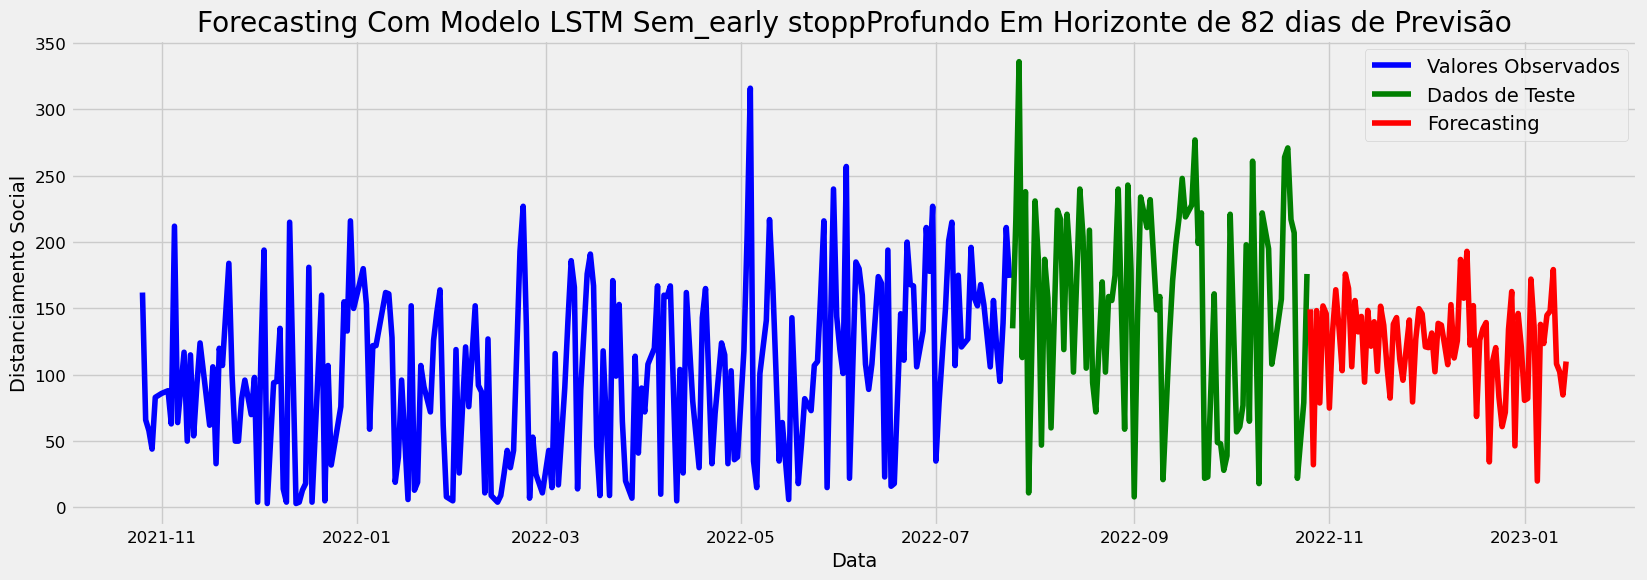

In [48]:
# Plot
plt.figure(figsize = (18, 6))

# Série original
plt.plot(target.index[0:272], target.values[0:272], label = 'Valores Observados', color = 'Blue')
plt.plot(target.index[272:], target.values[272:], label = 'Dados de Teste', color = 'green')

# Previsões
plt.plot(df_forecasting.index, df_forecasting['Prediction'], label = 'Forecasting',  color = 'Red')

plt.title('Forecasting Com Modelo LSTM Sem_early stoppProfundo Em Horizonte de 82 dias de Previsão')
plt.xlabel('Data')
plt.ylabel('Distanciamento Social')
plt.legend()
plt.show()

Todas as aulas deste curso foram adaptadas da timeline da Comunidade no Portal da DSA: www.datascienceacademy.com.br

# Fim